In [1]:
# import things
import math
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

train_path = './data/train.csv'
test_path = './data/test.csv'

In [2]:
class eda_data:
    def __init__(self, path):
        self.data = pd.read_csv(path)
        self.corrmat = self.data.corr()
        self.missing_data = self.get_missing()
    
    def concat_data(self, col_name):
        return pd.concat([self.data['SalePrice'], self.data[col_name]], axis=1)
    
    def scatter_plot(self, col_name):
        data = self.concat_data(col_name)
        data.plot.scatter(x=col_name, y='SalePrice', ylim=(0, 800000))
    
    def scatter_mul_plot(self, col_lst):
        sns.set()
        sns.pairplot(self.data[col_lst], size = 2.5)
        plt.show()
    
    def box_plot(self, col_name):
        data = self.concat_data(col_name)
        f, ax = plt.subplots(figsize=(16, 8))
        fig = sns.boxplot(x=col_name, y="SalePrice", data=data)
        fig.axis(ymin=0, ymax=800000);
    
    def correlation_matrix(self):
        k = 10 #number of variables for heatmap
        cols = self.corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
        cm = np.corrcoef(self.data[cols].values.T)
        sns.set(font_scale=1.25)
        hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
        plt.show()
        
    def get_missing(self):
        total = self.data.isnull().sum().sort_values(ascending=False)
        percent = (self.data.isnull().sum() / self.data.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data
        
    def check_nan(self, col_lst):
#         eda_df.data[['SalePrice']].isnull().values.any()
        for item in col_lst:
            if self.data[[item]].isnull().values.any():
                print(f"column: {item} has NaN data.")
            else:
                print(f"column: {item} is fine.")

In [13]:
class create_data:
    def __init__(self, path):
        self.data = pd.read_csv(path)
        self.missing_data = self.get_missing()
        
    def get_missing(self):
        total = self.data.isnull().sum().sort_values(ascending=False)
        percent = (self.data.isnull().sum() / self.data.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data
        
    def chose_model(self, model, using_col, cat_col):
        if model == 1:
            self.model_df = self.drop_nan_data(self.missing_data)
            
            id_lst = self.model_df['Id']
            house_price = self.model_df['SalePrice']
            house_price = np.log(house_price)
            tmp1_df = self.model_df[using_col]
            tmp1_df = (tmp1_df - tmp1_df.mean()) / tmp1_df.std()
            tmp1_df['SalePrice'] = house_price
            tmp1_df['Id'] = id_lst
            
            tmp2_df = self.model_df[cat_col]
            
            self.model_df = pd.merge(tmp1_df, tmp2_df, on='Id')
            self.model_df = self.model_df.drop(['Id'], axis=1)
            
            self.model_df = self.dum_data(self.model_df)
        else:
            self.model_df = self.handle()
            print('not build yet.')
        
    def drop_nan_data(self, missing_df):
        drop_data = self.data.drop((missing_df[missing_df['Total'] > 1]).index, 1)
        drop_data = drop_data.drop(drop_data.loc[drop_data['Electrical'].isnull()].index)
        self.drop_data = drop_data
        return drop_data
    
    def dum_data(self, data_df):
        return pd.get_dummies(data_df)
    
#     def out_liars(self):
    
class create_model:
    def __init__(
        self,
        train_df,
        label_col='SalePrice',
        learning_rate=0.02,
        steps=100,
        batch_size=10,
        periods=10,
        hidden_units=[8, 4],
        load_model=False,
        load_model_name='default',
        save_model=False,
        save_model_name='default',
    ):
        self.label = label_col
        # learning rate: optimizer
        self.learning_rate = learning_rate
        # steps, batch_size, periods: train
        self.steps = steps
        self.batch_size = batch_size
        self.periods = periods
        self.h_units = hidden_units
        # save model
        self.save_model = save_model
        self.load_model = load_model
        self.save_model_name = save_model_name
        self.load_model_name = load_model_name
        self.save_model_path = './model/' + self.save_model_name
        self.load_model_path = './model/' + self.load_model_name
        # split data
        self.te, self.tt, self.ve, self.vt = self.get_split_data(train_df)
        
        # create lenearRegressor
        self.feature_cols = self.get_feature_cols(train_df)
        self.optimizer = self.get_optimizer(learning_rate)
        
        if self.load_model:
            if self.save_model:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    model_dir=self.save_model_path,
                    warm_start_from=self.load_model_path
                )
            else:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    warm_start_from=self.load_model_path
                )
        else:
            if self.save_model:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
                #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    model_dir=self.save_model_path
                ) 
            else:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=[20, 10, 5],
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer
                )
        print('build the model')
    
    def get_split_data(self, train_df):
        # sample 80% for train data, 20% for vali data
        train_set, vali_set = self.split_train(train_df, 0.8)
        te, tt = self.get_e_t(train_set)
        ve, vt = self.get_e_t(vali_set)
        return te, tt, ve, vt
        
    def split_train(self, data_df, per):
        t_s = data_df.sample(frac=per, replace=False, random_state=42)
        v_s = data_df.loc[ set(data_df.index) - set(t_s.index)]
        return t_s, v_s
    
    def get_e_t(self, data_df):
        # data examples
        d_e = data_df.copy().drop(self.label, axis=1)
        # data targets
        d_t = pd.DataFrame()
        d_t[self.label] = data_df[self.label]
        return d_e, d_t
    
    def get_feature_cols(self, train_df):
        feature_df = train_df.copy().drop(self.label, axis=1)
        tmp_feature = [tf.feature_column.numeric_column(my_feature) for my_feature in feature_df]
#         if bin_age: # boolean:
#             tmp_age = tf.feature_column.numeric_column("Age")
#             bucketized_age = tf.feature_column.bucketized_column(
#               tmp_age, boundaries=get_quantile_based_boundaries(
#                 input_features["Age"], 4))
#             tmp_feature += [bucketized_age]
        return set(tmp_feature)
    
    def get_optimizer(self, learning_rate):
#         change the optimizer!!!!!!
        my_opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#         my_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt, 5.0)
        return my_opt
    
    def my_input_fn(
        self,
        features,
        targets,
        batch_size=1,
        shuffle=True,
        num_epochs=None
    ):
        # Convert pandas data into a dict of np arrays.
        features = {key:np.array(value) for key,value in dict(features).items()}
        # Construct a dataset, and configure batching/repeating.
        ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
        ds = ds.batch(batch_size).repeat(num_epochs)
        # Shuffle the data, if specified.
        if shuffle:
            ds = ds.shuffle(10000)
        # Return the next batch of data.
        features, labels = ds.make_one_shot_iterator().get_next()
        return features, labels
    
    def train(self):
        steps_per_period = self.steps / self.periods
        # create input function
        training_input_fn = lambda: self.my_input_fn(self.te, self.tt[self.label], batch_size=self.batch_size)
        predict_training_input_fn = lambda: self.my_input_fn(self.te, self.tt[self.label], num_epochs=1, shuffle=False)
        predict_vali_input_fn = lambda: self.my_input_fn(self.ve, self.vt[self.label], num_epochs=1, shuffle=False)
        
        print('Training model...')
        # recording RMSE
        training_rmse = []
        validation_rmse = []
        for period in range(self.periods):
            self.lr.train(
                input_fn=training_input_fn,
                steps=steps_per_period
            )
            
            # compute training predictions
            training_predictions = self.lr.predict(input_fn=predict_training_input_fn)
            training_predictions = np.array([item['predictions'][0] for item in training_predictions])
            # compute validation predictions
            validation_predictions = self.lr.predict(input_fn=predict_vali_input_fn)
            validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
            # get validation eval
            training_eval = self.lr.evaluate(input_fn=predict_training_input_fn)
            validation_eval = self.lr.evaluate(input_fn=predict_vali_input_fn)
            print("training_eval: {}".format(training_eval['average_loss']))
            print("validation_eval: {}".format(validation_eval['average_loss']))

            # compute training loss
            training_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(training_predictions, self.tt))
            # compute validation loss
            validation_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(validation_predictions, self.vt))
            # Occasionally print the current loss.
            print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
            # Add the loss metrics from this period to our list.
            training_rmse.append(training_root_mean_squared_error)
            validation_rmse.append(validation_root_mean_squared_error)
        
        print("Model training finished.")
        # saving model
        if self.save_model:
            print("Saving model...")
            
        # output a graph of loss metrics over periods.
        self.result_plot(training_rmse, validation_rmse)
        
    def result_plot(self, t_rmse, v_rmse):
        plt.ylabel("RMSE")
        plt.xlabel("Periods")
        plt.title("Root Mean Squared Error vs. Periods")
        plt.tight_layout()
        plt.plot(t_rmse, label="training")
        plt.plot(v_rmse, label="validation")
        plt.legend()
        

class predict_file:
    def __init__(self, model, test_df, predict_col):
        self.test_df = test_df
        self.predict_col = predict_col
        self.predict_input_fn = self.create_predict_fn()
        
        self.predictions = list(model.predict(input_fn=self.predict_input_fn))
        self.predictions = np.array([item['predictions'][0] for item in self.predictions])
        
        self.evaluation = test_df.copy().to_frame()
        self.evaluaion['SalePrice'] = self.predictions
    
    def create_predict_fn(self):
        predict_df = feature_eng(self.test_df)[self.predict_col]
        predict_input_fn = tf.estimator.inputs.pandas_input_fn(
            x=self.predict_df,
            num_epochs=1,
            shuffle=False
        )
        return predict_input_fn
    
    def save_predict(self, path):
        self.evaluation.to_csv(path, index=False)

build the model
Training model...
training_eval: 2.148818254470825
validation_eval: 2.1103522777557373
  period 00 : 1.47
training_eval: 1.5527373552322388
validation_eval: 1.4119096994400024
  period 01 : 1.25
training_eval: 0.7883687615394592
validation_eval: 0.7569862008094788
  period 02 : 0.89
training_eval: 1.0616779327392578
validation_eval: 1.0329514741897583
  period 03 : 1.03
training_eval: 1.0791479349136353
validation_eval: 1.054075837135315
  period 04 : 1.04
training_eval: 0.9488760828971863
validation_eval: 0.9273319840431213
  period 05 : 0.97
training_eval: 0.7101020216941833
validation_eval: 0.6503453254699707
  period 06 : 0.84
training_eval: 1.0951589345932007
validation_eval: 1.0347286462783813
  period 07 : 1.05
training_eval: 1.2952944040298462
validation_eval: 1.2571498155593872
  period 08 : 1.14
training_eval: 0.40997087955474854
validation_eval: 0.33673498034477234
  period 09 : 0.64
Model training finished.
Saving model...


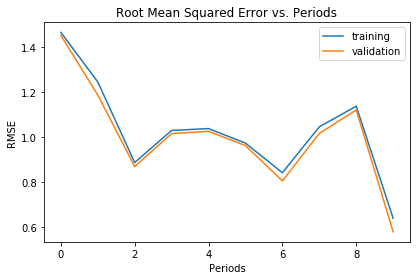

In [15]:
# mode l: just drop NaN data

# using_col = ['SalePrice', 'OverallQual', 'TotalBsmtSF', YearBuilt']
using_col = ['Id', 'SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath']
category_col = ['Id', 'SaleType', 'SaleCondition']
# predict_col = using_col[1:]

# loading csv file
train_df = create_data(train_path)
# test_df = create_data(test_path)

# drop NaN data
train_df.chose_model(1, using_col, category_col)
# train_df.model_df.head()

# create model
model = create_model(
    train_df=train_df.model_df, 
    save_model=True, 
    save_model_name="model1_test_v18",
#     load_model=True, 
#     load_model_name="model1_test_v7",
    learning_rate=0.02,
#     hidden_units=[3]
)

# training model
model.train()

In [39]:
# model 2: deal with NaN data
2*4

8

In [48]:
# model 3: deal with NaN data & out lier data

In [89]:
test = eda_data(train_path)


In [116]:
2**4

16